# KS

Kolmogorov-Smirnov metric (ks metric) is derived from K-S test. K-S test measures the distance between two plotted cumulative distribution functions (CDF).   
To use it as a metric for classification machine learning problem we see the distance of plotted CDF of target and non-target.  
The model that produces the greatest amount of separability between target and non-target distribution would be considered the better model.  


KS metric ranges from 0 to 100.

## Why KS?

- KS is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.

- KS is threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

## KS Table

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
# sample dataset and sample model

# make sample dataset
X, y = make_classification(
    n_samples=1000, class_sep=0.3, random_state=0
)  # 1000 samples with 20 features

# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# simple Logistic Model
model = LogisticRegression(random_state=23)
model.fit(X_train, y_train)

# predictions
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]
print(f"{X_train.shape = }\n{y_train.shape = }")
print(f"{X_test.shape = }\n{y_test.shape = }")
print(f"{y_train_pred.shape = }\n{y_test_pred.shape = }")

X_train.shape = (670, 20)
y_train.shape = (670,)
X_test.shape = (330, 20)
y_test.shape = (330,)
y_train_pred.shape = (670,)
y_test_pred.shape = (330,)


### Group into Deciles

In [3]:
df = pd.DataFrame()
df["score"] = y_test_pred
# one hot encoding the dependent variable
df["class_0"] = 1 - y_test
df["class_1"] = y_test

# bucket/bin prediction after ordering them
df["bucket"] = pd.qcut(df.score.rank(method="first"), 10, labels=list(range(0, 10, 1)))

df.head()

,score,class_0,class_1,bucket
0,0.314387,1,0,1
1,0.131233,1,0,0
2,0.159981,0,1,0
3,0.350067,1,0,2
4,0.830346,0,1,8


### Target Distribution

In [4]:
grouped = df.groupby("bucket", as_index=False)

ks_table = pd.DataFrame()
ks_table["min_score"] = grouped.min().score
ks_table["max_score"] = grouped.max().score
ks_table["n_class_0"] = grouped.sum().class_0
ks_table["n_class_1"] = grouped.sum().class_1
ks_table["n_total"] = ks_table.n_class_0 + ks_table.n_class_1

ks_table

,min_score,max_score,n_class_0,n_class_1,n_total
0,0.035500,0.224967,21,12,33
1,0.226262,0.327676,27,6,33
2,0.328646,0.377685,19,14,33
3,0.381554,0.437930,25,8,33
4,0.442221,0.491976,23,10,33
5,0.495512,0.575724,17,16,33
6,0.577944,0.671211,9,24,33
7,0.671344,0.757899,6,27,33
8,0.765076,0.874251,4,29,33
9,0.874542,0.988560,7,26,33


```{note}
Sometimes DV: 0 or 1 is called Goods/Bads. Depending on the problem either 0 or 1 is defined as `good`.
```

<AxesSubplot:>

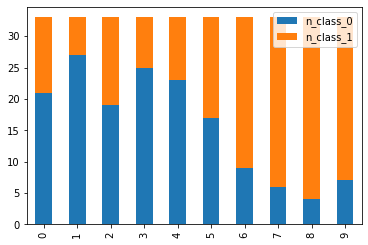

In [5]:
ks_table[
    [
        "n_class_0",
        "n_class_1",
    ]
].plot.bar(stacked=True)

The graph above show the difference in classification for each decicles. 

```{note}
This difference varies depending on performance.
```{list-table}
:header-rows: 1

* - KS 25
  - KS 50
  - KS 75
* - ![alt](../_assets/ks_25.png) 
  - ![alt](../_assets/ks_50.png)
  - ![alt](../_assets/ks_75.png)
```

```

### Calculating KS

In [6]:
count_class_0 = df.class_0.sum()
count_class_1 = df.class_1.sum()

ks_table["%_class_0"] = (ks_table.n_class_0 / count_class_0) * 100
ks_table["%_class_1"] = (ks_table.n_class_1 / count_class_1) * 100

ks_table["cs_class_0"] = (ks_table.n_class_0 / count_class_0).cumsum() * 100
ks_table["cs_class_1"] = (ks_table.n_class_1 / count_class_1).cumsum() * 100

ks_table["cs_diff"] = np.abs(ks_table["cs_class_0"] - ks_table["cs_class_1"])

ks_table.style.format(
    "{:.1f}%", subset=["%_class_0", "%_class_1", "cs_class_0", "cs_class_1", "cs_diff"]
)

,min_score,max_score,n_class_0,n_class_1,n_total,%_class_0,%_class_1,cs_class_0,cs_class_1,cs_diff
0,0.035500,0.224967,21,12,33,13.3%,7.0%,13.3%,7.0%,6.3%
1,0.226262,0.327676,27,6,33,17.1%,3.5%,30.4%,10.5%,19.9%
2,0.328646,0.377685,19,14,33,12.0%,8.1%,42.4%,18.6%,23.8%
3,0.381554,0.437930,25,8,33,15.8%,4.7%,58.2%,23.3%,35.0%
4,0.442221,0.491976,23,10,33,14.6%,5.8%,72.8%,29.1%,43.7%
5,0.495512,0.575724,17,16,33,10.8%,9.3%,83.5%,38.4%,45.2%
6,0.577944,0.671211,9,24,33,5.7%,14.0%,89.2%,52.3%,36.9%
7,0.671344,0.757899,6,27,33,3.8%,15.7%,93.0%,68.0%,25.0%
8,0.765076,0.874251,4,29,33,2.5%,16.9%,95.6%,84.9%,10.7%
9,0.874542,0.988560,7,26,33,4.4%,15.1%,100.0%,100.0%,0.0%


`%_class_0` for 0th bin is 21 / total number of class_0.   
`cs_class_0` is the same but cumulatively summed.  
`cs_diff` is the difference between `cs_class_0` and `cs_class_1`

#### KS

KS is the max difference between cumulatively summed rate of target and cumulatively summed non-target. i.e. maximum value of `cs_diff`

In [7]:
ks = ks_table["cs_diff"].max()
print(f"KS = {round(ks,2)}")

KS = 45.17


### Plot Binned KS

In [13]:
 ks_table.loc[ks_tier, "cs_class_0"] / 100,

(0.8354430379746836,)

In [14]:
ks_table.loc[ks_tier, "cs_class_1"] / 100,

(0.38372093023255816,)

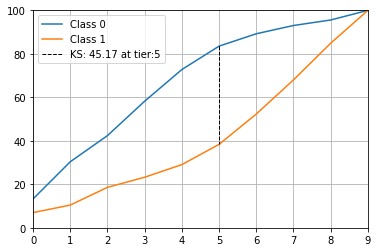

In [26]:
fig, ax = plt.subplots(1, 1)
ax.plot(ks_table["cs_class_0"], label="Class 0")
ax.plot(ks_table["cs_class_1"], label="Class 1")
print()
ax.axvline(
    x=ks_tier,
    ymin=ks_table.loc[ks_tier, "cs_class_0"] / 100,
    ymax=ks_table.loc[ks_tier, "cs_class_1"] / 100,
    c="black",
    linewidth=1,
    linestyle="--",
    label=f"KS: {ks_table['cs_diff'].max().round(2)} at tier:{ks_tier}",
)
ax.set_xlim([0, 9])
ax.set_ylim([0, 100])
# ax.set_xlabel("Tiers")
# ax.set_ylabel("Cumilative Percentage")
# ax.set_xticks(ks_table.index)
ax.grid()
ax.legend()
plt.show()

```{note}
Binned KS are useful when you intent to have different actions for differnt bins. For example in the case of credit scoring you might give a higher APR (interest rate) to people falling in higher bins.
```

## True KS  

Not all problems need the prediction probabilities to be group. True KS would be the max separability between target and non-target distribution without grouping them.   

In [31]:
data = pd.DataFrame({'score':y_test_pred,'dv':y_test})
data['good'] = (data['dv']==1).astype(np.int64)
data['bad'] = 1-data['good']
data = data.sort_values('score')
data.reset_index(inplace=True,drop=True)
data['bads'] = data.bad.cumsum()
data['goods'] = data.good.cumsum()
data['cum_good_pct'] = data.good.cumsum() / data.good.sum()
data['cum_bad_pct'] = data.bad.cumsum() / data.bad.sum()
data['ks'] = np.abs(data['cum_good_pct']-data['cum_bad_pct'])

data

,score,dv,good,bad,bads,goods,cum_good_pct,cum_bad_pct,ks
0,0.035500,0,0,1,1,0,0.000000,0.006329,0.006329
1,0.049758,0,0,1,2,0,0.000000,0.012658,0.012658
2,0.057529,0,0,1,3,0,0.000000,0.018987,0.018987
3,0.067903,1,1,0,3,1,0.005814,0.018987,0.013173
4,0.077144,0,0,1,4,1,0.005814,0.025316,0.019503
...,...,...,...,...,...,...,...,...,...
325,0.953260,1,1,0,156,170,0.988372,0.987342,0.001030
326,0.955026,1,1,0,156,171,0.994186,0.987342,0.006844
327,0.967771,1,1,0,156,172,1.000000,0.987342,0.012658
328,0.981576,0,0,1,157,172,1.000000,0.993671,0.006329


In [32]:
data.ks.max()

0.4691639682072417

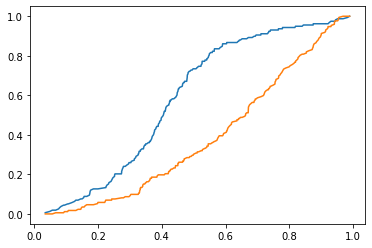

In [33]:
fig, ax = plt.subplots(1, 1)
ax.plot(data.set_index('score')['cum_bad_pct'], label="Class 0")
ax.plot(data.set_index('score')['cum_good_pct'], label="Class 1")

plt.show()

In [34]:
# create 2D array with y_true, y_pred
ks_arr = np.dstack((y_test, y_test_pred))[0]

# order by score 
ks_arr = ks_arr[np.argsort(ks_arr[:, 1], kind='stable')]

# counts of 0s and 1s
y_true_counts = np.unique(ks_arr[:, 0], return_counts=True)[1]

# cumilative sum by total counts of 0s and 1s 
cs_0 = (1 - ks_arr[:, 0]).cumsum() / y_true_counts[0]
cs_1 = (ks_arr[:, 0]).cumsum() / y_true_counts[1]

# seperation between cumilative percent 
cs_diff = np.abs(cs_0 - cs_1)

# ks : max seperation 
ks = cs_diff.max() * 100 
ks

46.916396820724174

In [35]:
ks_threshold = ks_arr[cs_diff.argmax(),1]
ks_threshold

0.5653306828276777

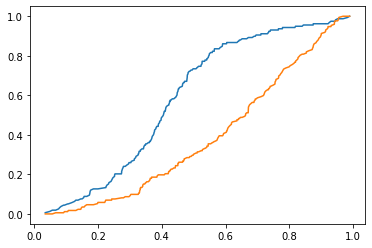

In [36]:
fig, ax = plt.subplots(1, 1)
ax.plot(ks_arr[:,1], cs_0, label="Class 0")
ax.plot(ks_arr[:,1],cs_1, label="Class 1")

# ax.plot(data.set_index('score')['cum_good_pct'], label="Class 1")
ks_threshold = cs_diff.argmax()

plt.show()

In [ ]:
https://github.com/reiinakano/scikit-plot/blob/2dd3e6a76df77edcbd724c4db25575f70abb57cb/scikitplot/metrics.py#L29